In [4]:
from scipy.stats import chi2_contingency, mannwhitneyu, shapiro, kruskal
import scikit_posthocs as sp
import pandas as pd

In [ ]:
df = pd.read_csv(r"C:\Users\user\Desktop\churn.csv") #Читаем датафрэйм
df.head() 

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [ ]:
df.last_trip_date = pd.to_datetime(df.last_trip_date)
df.signup_date = pd.to_datetime(df.signup_date) #Приводим даты к нужному формату
df['days_since_last_trip'] = df.last_trip_date.max() - df.last_trip_date #Считаем сколько времени прошло с последней активности клиента
df['days_since_last_trip'] = df['days_since_last_trip'].dt.days #Записываем полученные данные в отдельную колонку
df['churn'] = df.days_since_last_trip.apply(lambda x: 'churn' if x > 30 else 'not_churn') #Создаём в датафрэйме отметку покинул ли нас клиент(если он отсутствовал больше 30 дней)
df[['days_since_last_trip', 'churn']]

,days_since_last_trip,churn
0,14,not_churn
1,57,churn
2,175,churn
3,2,not_churn
4,108,churn
...,...,...
49995,26,not_churn
49996,157,churn
49997,40,churn
49998,167,churn


In [ ]:
churn_city = pd.crosstab(df.city, df.churn) #Создаём датафрэйм с количеством ушедших и оставшихся клиентов с разбивкой по городам
churn_city

churn,churn,not_churn
city,,
Astapor,12306,4228
King's Landing,3767,6363
Winterfell,15123,8213


In [ ]:
stat, p,dof , expected = chi2_contingency(churn_city) #Рассчитываем pvalue при помощи критерия Пирсона
p#Он близок к нулю

np.float64(0.0)

In [ ]:
ast = df.query('city == "Astapor"').trips_in_first_30_days
king = df[df.city == "King's Landing"].trips_in_first_30_days
wint = df.query('city == "Winterfell"').trips_in_first_30_days #Создаём отдельные датафрэймы с количеством поездок в первые 30 дней для каждого города

In [ ]:
print(shapiro(ast.sample(1000, random_state=17)))
print(shapiro(king.sample(1000, random_state=17)))
print(shapiro(wint.sample(1000, random_state=17))) #При помощи теста Шапиро-Уилка проверяем данные на нормальность распределения

ShapiroResult(statistic=np.float64(0.5414699844895436), pvalue=np.float64(4.822611722650788e-45))
ShapiroResult(statistic=np.float64(0.6132173383426862), pvalue=np.float64(1.6834188295275776e-42))
ShapiroResult(statistic=np.float64(0.5455789939910616), pvalue=np.float64(6.602753909260042e-45))


In [ ]:
kruskal(ast, king,wint) #Для определения сущесвуют ли статистически значимые различия используем метод Краскела-Уоллиса

KruskalResult(statistic=np.float64(221.32105325317454), pvalue=np.float64(8.724567791938856e-49))

In [ ]:
dat = [ast, king,wint]
sp.posthoc_dunn(dat, p_adjust='holm') #С помощью метода Данна определяем между какими группами различия

,1,2,3
1,1.000000e+00,1.313616e-09,2.448501e-49
2,1.313616e-09,1.000000e+00,8.440212e-10
3,2.448501e-49,8.440212e-10,1.000000e+00


In [34]:
needed_df = df[['city', 'trips_in_first_30_days']]

In [ ]:
sp.posthoc_dunn(needed_df,val_col= 'trips_in_first_30_days', group_col= 'city', p_adjust='holm') #Второй способ

,Astapor,King's Landing,Winterfell
Astapor,1.000000e+00,1.313616e-09,2.448501e-49
King's Landing,1.313616e-09,1.000000e+00,8.440212e-10
Winterfell,2.448501e-49,8.440212e-10,1.000000e+00


In [ ]:
churn = df.query('churn == "churn"').trips_in_first_30_days
not_churn = df.query('churn == "not_churn"').trips_in_first_30_days #создаём подвыборки с количеством поездок в первые 30 дней для ушедших и оставшихся клиентов

In [ ]:
mannwhitneyu(churn, not_churn) #Сравниваем распределения данных для этих подвыборок с помощью критерия Манна-Уитни

MannwhitneyuResult(statistic=np.float64(234767452.0), pvalue=np.float64(0.0))

In [39]:
import seaborn as sns

<Axes: xlabel='churn', ylabel='trips_in_first_30_days'>

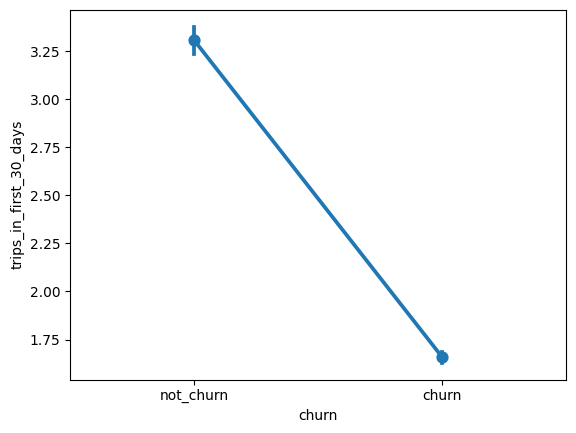

In [ ]:
sns.pointplot(x = 'churn', y = 'trips_in_first_30_days', data=df) #Строим график с сравнением среднего количества поездок для выборок